In [43]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import tensorflow.compat.v1 as tf
import random

tf.disable_v2_behavior()
print("Num GPUs Available: ", tf.test.is_built_with_cuda())

path="./data"
IMG_SIZE=100

Num GPUs Available:  True


In [44]:
dog_files=os.listdir(path+'/dogs')
wolf_files=os.listdir(path+'/wolves')
image_paths = []
#label: 0 for dog ,1 for wolf # woof -woof
labels=[]
img=[]
for file in dog_files:
    image = cv2.imread(path+'/'+'dogs/'+file)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    norm_image = image/255.0 
    # Creating and saving each image in the form of numerical data in an array
    img.append(image.flatten())
    labels.append([1,0])
    image_paths.append(path+'/'+'dogs/'+file)
for file in wolf_files:
    image = cv2.imread(path+'/'+'wolves/'+file)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    norm_image = image/255.0 
          #Creating and saving each image in the form of numerical data in an array
    image_paths.append(path+'/'+'wolves/'+file)

    img.append(image.flatten())
    labels.append([0,1])

In [45]:
df={'data':img,'label':labels}
df=pd.DataFrame(df)
df = df.sample(frac=1).reset_index(drop=True)

[0, 1]


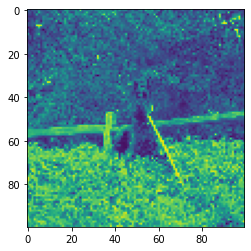

In [46]:
plt.imshow(df.data[0].reshape(IMG_SIZE,IMG_SIZE))
print(df.label[1])
#main_train_df,test_df=train_test_split(df, test_size=0.2,shuffle=True,random_state=42)
#train_df,val_df=train_test_split(main_train_df, test_size=0.1,shuffle=True,random_state=42)
#random.shuffle(df)
train_df=df[:1400]
val_df=df[1400:1600]
test_df=df[1600:]


In [47]:
x_train=list(train_df.data)
y_train=list(train_df.label)
x_val=list(val_df.data)
y_val=list(val_df.label)
x_test=list(test_df.data)
y_test=list(test_df.label)

In [89]:
X=tf.placeholder(tf.float32,[None,IMG_SIZE*IMG_SIZE])
Y=tf.placeholder(tf.float32,[None,2])
W=tf.Variable(tf.zeros([IMG_SIZE*IMG_SIZE,2]))
b=tf.Variable(tf.zeros([2]))
#alpha=tf.Variable(0)
eps = 1e-12

In [90]:
h =tf.matmul(X,W)+b#1 / (1.0 + tf.exp(-(tf.matmul(img,W) + b)))
# softmax
actv = tf.nn.sigmoid(h)
# cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
prediction = tf.argmax(actv,1)
correct_prediction = tf.equal(prediction, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# loss1 = -(Y * tf.log(h + eps) + (1 - Y) * tf.log( 1 - h + eps))
loss1=tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=h)
loss = tf.reduce_mean(loss1)
# loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(actv), reduction_indices=1)) 
# loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1))
#alpha = arr[j]
update = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

#loss_data = []


In [78]:
batch_size = 140
num_batches = int(len(x_train)/batch_size)

def getBatch(data,d_label,curr_index,batch_size):
    return data[curr_index*batch_size:(curr_index+1)*batch_size],d_label[curr_index:curr_index+batch_size]


In [91]:
#arr=np.linspace(0.00000001,0.0000001,num=50)
def printGraph(train_loss,test_lostt,train_acc,test_acc):
    # print(alphas)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.title("Loss")
    plt.legend(['train','test'])
    # plt.xlabel(index)
    plt.show()
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title("Accuracy")
    plt.legend(['train','test'])
    # plt.xlabel(index)
    plt.show()

In [ ]:
max_acc = []
max_acc_v = []
train_loss_arr=[]
test_loss_arr=[]
train_acc_arr=[]
test_acc_arr=[]
ac=[]
ac_v=[]
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for k in range(0,5000):
    curr_index = 0
    # for i in range(0,num_batches):
        # batch_x,batch_y = getBatch(x_train,y_train,i,batch_size)
    if k%10==0:
        #loss_data.append(loss.eval(session= sess, feed_dict = {X:x_train,Y:y_train}))
        train_acc,train_loss = sess.run([accuracy,loss], feed_dict={X:x_train,Y:y_train})
        print (" Training accuracy: %.10f, Training loss: %.10f" % (train_acc, train_loss))
        val_acc,val_loss = sess.run([accuracy,loss], feed_dict={X:x_val,Y:y_val})
        test_acc_arr.append(float(val_acc)) 
        train_acc_arr.append(float(train_acc))
        test_loss_arr.append(float(val_loss))
        train_loss_arr.append(float(train_loss))
    # print (" Validation accuracy: %.10f, Validation loss: %.10f" % (val_acc,val_loss))
    sess.run([update],feed_dict={X:x_train,Y:y_train})
printGraph(train_loss_arr,test_loss_arr,train_acc_arr,test_acc_arr)

#printGraph(ac_v,ac)

    # max_acc.append(np.max(ac))



In [ ]:
# # arr =[alpha,alpha+alpha/2]
# max_acc = []
# max_acc_v = []
# train_loss=[]
# test_loss=[]
# train_acc=[]
# test_acc=[]
# 
# alphas = []
# for j in range(0,len(arr)):
#     ac=[]
#     ac_v=[]
#     loss_t=[]
#     loss_v=[]
#     #print(f"shitttttttt {arr[j]}")
#    # update = tf.train.GradientDescentOptimizer(arr[j]).minimize(loss)
#     sess=tf.Session()
#     sess.run(tf.global_variables_initializer())
#     alpha.assign(arr[j])
#     #sess.run(alpha,feed_dict={arr[j]})
#     for k in range(0,1000):
#         curr_index = 0
#         for i in range(0,num_batches):
#             batch_x,batch_y = getBatch(x_train,y_train,i,batch_size)
#             if i%14==0:
#                 loss_data.append(loss.eval(session= sess, feed_dict = {X:batch_x,Y:batch_y}))
#                 tra_acc,tra_loss = sess.run([accuracy,loss], feed_dict={X:batch_x,Y:batch_y})
#                 #print (" Training accuracy: %.10f, Training loss: %.10f" % (tra_acc, tra_loss))
#                 tes_acc,tes_loss = sess.run([accuracy,loss], feed_dict={X:batch_x,Y:batch_y})
#                 ac_v.append(float(tes_acc))
#                 ac.append(float(tra_acc))
#                 loss_v.append(float(tes_loss))
#                 loss_t.append(float(tra_loss))
#                 #print(" Validation accuracy: %.10f, Validation loss: %.10f" % (tes_acc,tes_loss))
#             sess.run([update],feed_dict={X:batch_x,Y:batch_y})
#     # max_acc.append(np.max(ac))
#     alphas.append(float(arr[j]))
#     test_acc.append(np.max(ac_v)) 
#     train_acc.append(np.max(ac))
#     test_loss.append(np.min(loss_v))
#     train_loss.append(np.min(loss_t))
# printGraph(train_loss,test_loss,train_acc,test_acc)
# # print(loss_data)
# print(max_acc_v)

In [ ]:
def printGraph(train_loss,test_lostt,train_acc,test_acc):
    # print(alphas)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.title("Loss")
    plt.legend(['train','test'])
    # plt.xlabel(index)
    plt.show()
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title("Accuracy")
    plt.legend(['train','test'])
    # plt.xlabel(index)
    plt.show()

In [ ]:
def getBatch(data,d_label,curr_index,batch_size):
    return data[curr_index:curr_index+batch_size],d_label[curr_index:curr_index+batch_size]

In [ ]:
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={X: x_val, Y: y_val}))

In [ ]:
plt.ylabel('loss')
plt.xlabel('iteration in 1000')
plt.plot(loss_data)


In [ ]:

print(sess.run(accuracy, feed_dict={X: x_val, Y: y_val}))

In [ ]:
k={'data':x,'label':labels}
type(np.array(k['data']))

In [ ]:
np.array(k['data'])

In [ ]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((train_df.data, train_df.label))